# Import Packages

In [2]:
import h5py
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Read and Proprocess Data

https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation.git

## Read Data

In [3]:
matFilename = 'data/2018-02-20_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(matFilename, 'r')

In [4]:
list(f.keys())

['#refs#', '#subsystem#', 'batch', 'batch_date']

In [5]:
batch = f['batch']

In [6]:
list(batch.keys())

['Vdlin',
 'barcode',
 'channel_id',
 'cycle_life',
 'cycles',
 'policy',
 'policy_readable',
 'summary']

## Preprocess Data

In [7]:
num_cells = batch['summary'].shape[0]

bat_dict = {}

for i in range(num_cells):
    # Cycle life
    cl = np.array(f[batch['cycle_life'][i, 0]])

    # Decode MATLAB string
    policy_bytes = np.array(f[batch['policy_readable'][i, 0]])
    policy = ''.join([chr(c[0]) if isinstance(c, np.ndarray) else chr(c) for c in policy_bytes])

    # Summary
    summary_group = f[batch['summary'][i, 0]]
    summary = {}
    for key in summary_group.keys():
        data = summary_group[key][0, :]
        # Dereference if needed
        arr_list = []
        for item in data:
            if isinstance(item, h5py.Reference):
                arr_list.append(np.array(f[item]))
            else:
                arr_list.append(np.array(item))
        summary[key] = np.hstack(arr_list)

    # Cycles
    cycles_group = f[batch['cycles'][i, 0]]
    cycle_dict = {}
    for j in range(cycles_group['I'].shape[0]):
        cd = {}
        for field in cycles_group.keys():
            dataset = cycles_group[field][j, 0]
            if isinstance(dataset, h5py.Reference):
                cd[field] = np.array(f[dataset])
            else:
                cd[field] = np.array(dataset)
        cycle_dict[str(j)] = cd

    bat_dict[f'b1c{i}'] = {
        'cycle_life': cl,
        'charge_policy': policy,
        'summary': summary,
        'cycles': cycle_dict
    }

print(f"Loaded {len(bat_dict)} cells successfully.")


Loaded 47 cells successfully.


## Examine Data

In [279]:
bat_dict.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b1c46'])

In [280]:
bat_dict['b1c0']['summary'].keys()

dict_keys(['IR', 'QCharge', 'QDischarge', 'Tavg', 'Tmax', 'Tmin', 'chargetime', 'cycle'])

#### QDischarge

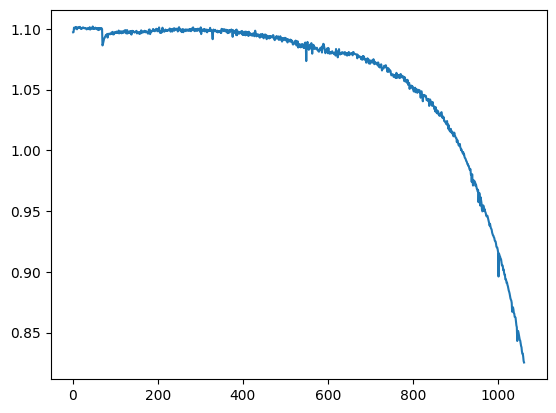

In [281]:
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['QDischarge'])

#### QCharge

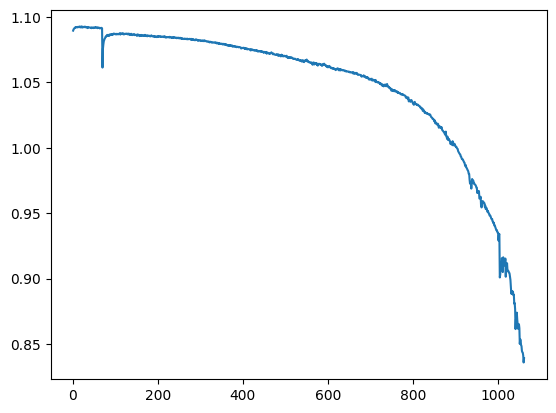

In [282]:
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['QCharge'])

#### Tavg

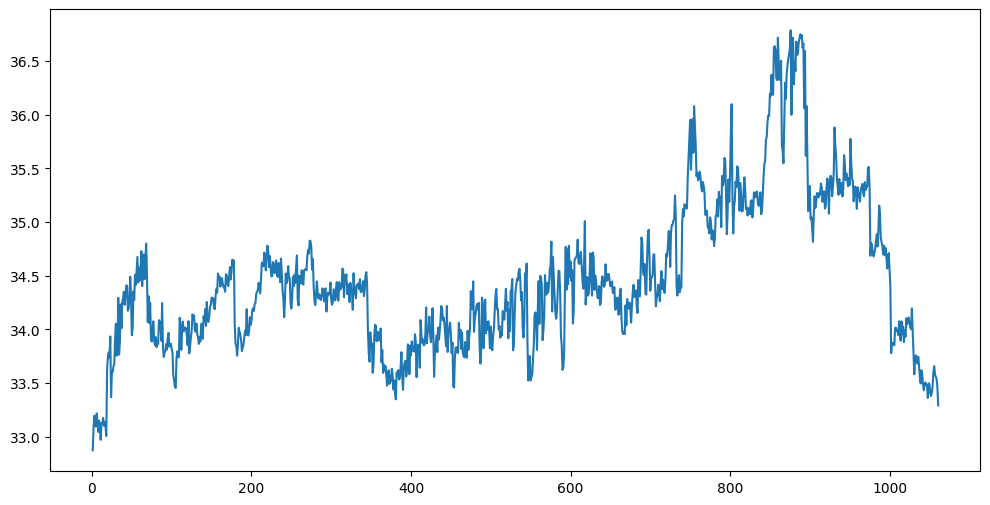

In [283]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['Tavg'])

#### Tmax

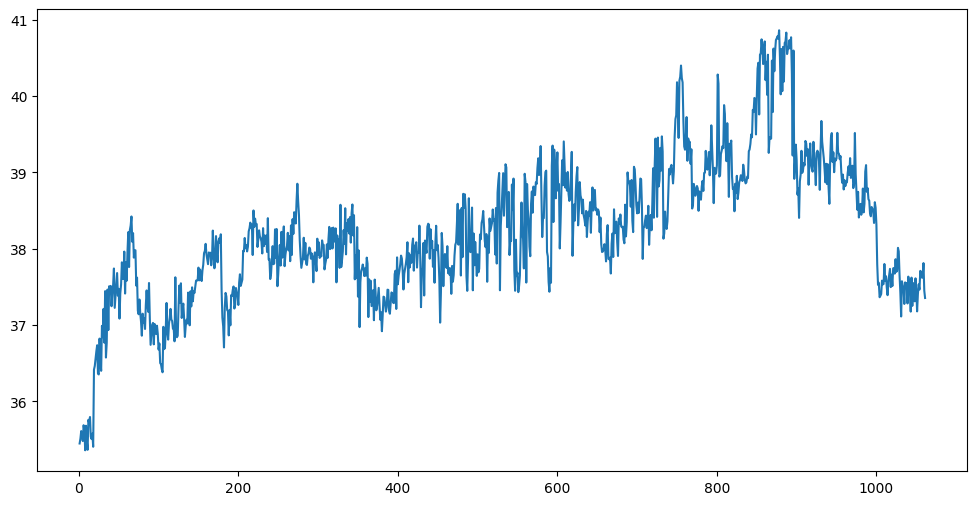

In [284]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['Tmax'])

#### Tmin

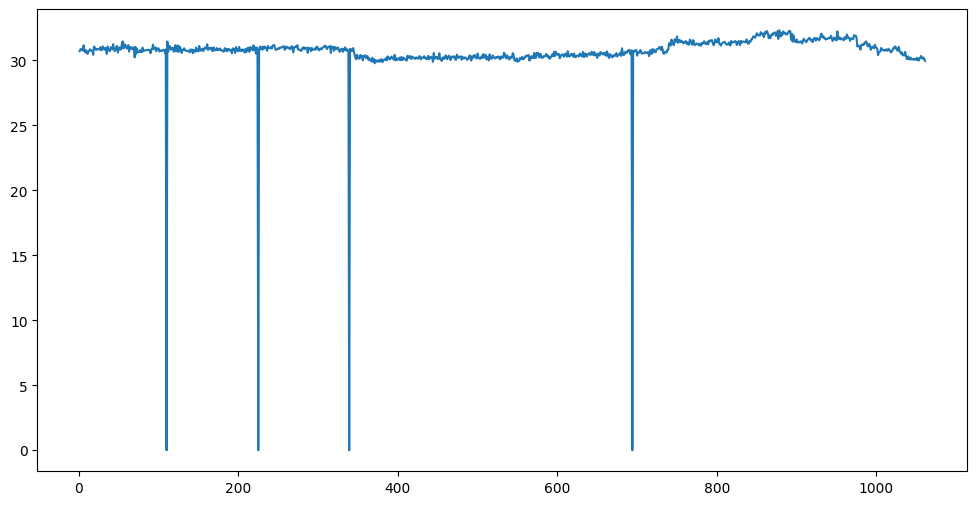

In [285]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['Tmin'])

#### chargetime

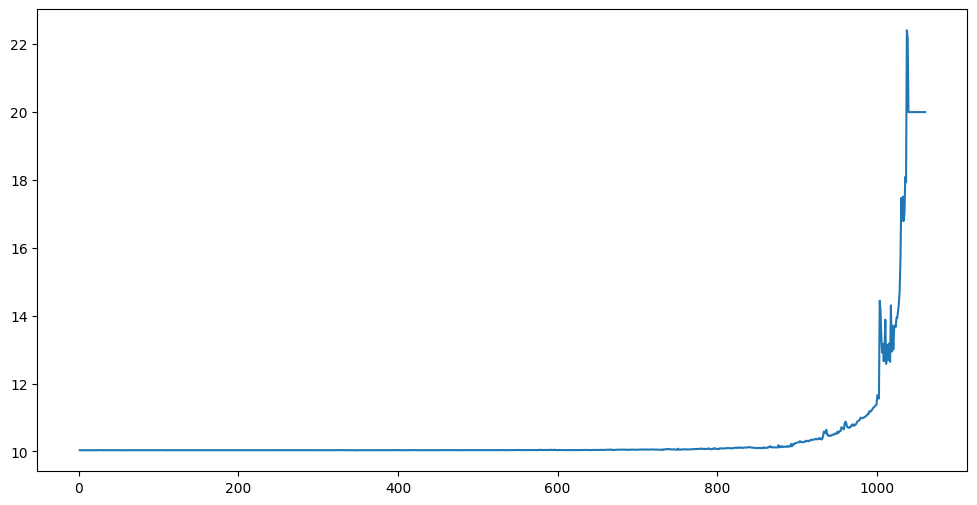

In [286]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['chargetime'])

#### IR

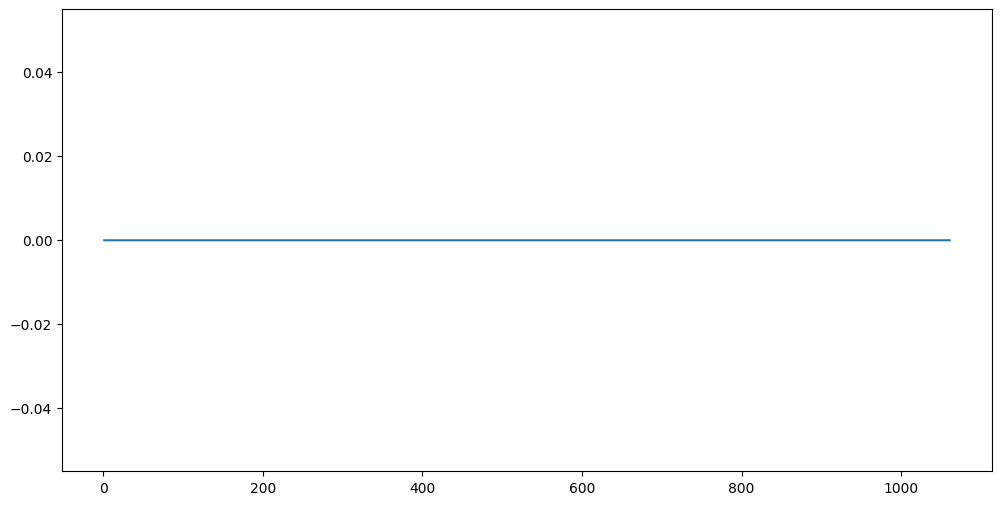

In [287]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['IR'])

## Data Description

1. IR--Internal Resistance for the current
2. QCharge--Charge capacity. Units are usually Ah. Declines over time due to material degradation.
3. QDischarge--Discharge capacity. Units are usually Ah. Declines over time. 
4. Tavg--Mean operating temperature during a cycle. 
5. Tmax--Maximum operating temperatue during a cycle. 
6. Tmin--Minimum operating temperature during a cycle.
7. chargetime--Time taken to charge.
8. cycle--Cycle is the count of charge–discharge loops.

# Functions for Prediction

## Single -> Single (1->1)

### Function to Train

In [11]:
def train_lstm(cycles, train, window_size=10, epochs=50, batch_size=16):
    
    # Convert to numpy arrays
    train = np.array(train).reshape(-1, 1)
    
    # Scale data between 0 and 1
    scaler = MinMaxScaler()
    q_scaled = scaler.fit_transform(train)
    
    # Train-test split (80-20)
    split_idx = int(len(q_scaled) * 0.8)
    train, test = q_scaled[:split_idx], q_scaled[split_idx:]
    
    # Function to create sequences
    def create_sequences(data, window_size):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i+window_size])
            y.append(data[i+window_size])
        return np.array(X), np.array(y)
    
    X_train, y_train = create_sequences(train, window_size)
    X_test, y_test = create_sequences(test, window_size)
    
    # Reshape for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build LSTM model
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(window_size, 1)),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    return model, scaler, X_test, y_test

### Function to Test

In [12]:
def test_lstm(model, scaler, X_test, y_test):

    # Predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform back to original scale
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

    return y_pred, y_test

## Multivariate -> Single (n -> 1)

### Function to Train

In [15]:
def train_lstm_multivariate(cycles, features, target, window_size=10, epochs=50, batch_size=16):
    # Convert to numpy arrays
    features = np.array(features)
    target = np.array(target).reshape(-1, 1)

    # Scale features and target separately
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    features_scaled = scaler_X.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target)

    # Train-test split (80-20)
    split_idx = int(len(features_scaled) * 0.8)
    train_X, test_X = features_scaled[:split_idx], features_scaled[split_idx:]
    train_y, test_y = target_scaled[:split_idx], target_scaled[split_idx:]

    # Create sequences
    def create_sequences(data_X, data_y, window_size):
        X, y = [], []
        for i in range(len(data_X) - window_size):
            X.append(data_X[i:i+window_size])
            y.append(data_y[i+window_size])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_X, train_y, window_size)
    X_test, y_test = create_sequences(test_X, test_y, window_size)

    # Build LSTM model
    model = Sequential([
        LSTM(100, activation='tanh', input_shape=(window_size, features.shape[1])),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    return model, scaler_X, scaler_y, X_test, y_test

### Function to Test

In [16]:
def test_lstm(model, scaler_y, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)

    # Inverse transform back to original scale
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)

    return y_pred, y_test

## Multivariate -> Multivariate (n->n)

### Function to Train

In [20]:
def train_lstm_multivariate_2(cycles, features, targets, window_size=10, epochs=50, batch_size=16):
    # Convert to numpy arrays
    features = np.array(features)
    targets = np.array(targets)  # can now be multi-dimensional

    # Scale features and targets separately
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    features_scaled = scaler_X.fit_transform(features)
    targets_scaled = scaler_y.fit_transform(targets)

    # Train-test split (80-20)
    split_idx = int(len(features_scaled) * 0.8)
    train_X, test_X = features_scaled[:split_idx], features_scaled[split_idx:]
    train_y, test_y = targets_scaled[:split_idx], targets_scaled[split_idx:]

    # Create sequences
    def create_sequences(data_X, data_y, window_size):
        X, y = [], []
        for i in range(len(data_X) - window_size):
            X.append(data_X[i:i+window_size])
            y.append(data_y[i+window_size])  # multi-output handled naturally
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_X, train_y, window_size)
    X_test, y_test = create_sequences(test_X, test_y, window_size)

    # Build LSTM model
    model = Sequential([
        LSTM(100, activation='tanh', input_shape=(window_size, features.shape[1])),
        Dense(targets.shape[1])  # predict multiple outputs
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    return model, scaler_X, scaler_y, X_test, y_test

### Function to Test

In [21]:
def test_lstm_2(model, scaler_y, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)

    # Inverse transform back to original scale
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)

    return y_pred, y_test

# Functions to Evaluate

## Functions to Plot

In [ ]:
def plot_predict_two_features(y_pred, y_test, y_title, y_label):

    plt.figure(figsize=(10,6))
    plt.plot(range(len(y_test)), y_test, label="Actual", color="blue", alpha=1)
    plt.plot(range(len(y_pred)), y_pred, label=y_label, color="red", linestyle="dashed", alpha=1)


    plt.xlabel('No. of Cycles', fontsize=24)
    plt.ylabel(y_title, fontsize=24)
    plt.tick_params(labelsize=20)
    plt.legend(fontsize=16)
    #plt.title("LSTM Prediction of Battery Capacity Fade")
    plt.grid(True, linestyle='--', alpha=0.8)
    plt.show()
    
    return

In [ ]:
def plot_predict_three_features(y_pred, y_sim, y_test, y_title):

    plt.figure(figsize=(10,6))
    plt.plot(range(len(y_test)), y_test, label="Actual", color="blue")
    plt.plot(range(len(y_pred)), y_pred, label="Prediction", color="red", linestyle="dashed")
    plt.plot(range(len(y_sim)), y_sim, label="Simulation", color="green", linestyle="dashed")


    plt.xlabel('No. of Cycles', fontsize=20)
    plt.ylabel(y_title, fontsize=20)
    plt.tick_params(labelsize=16)
    plt.legend(fontsize=12)
    #plt.title("LSTM Prediction of Battery Capacity Fade")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    return

## Functions to Find Errors

In [ ]:
def evaluate_predictions(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Avoid division by zero in MAPE
    non_zero_idx = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE (%)": mape
    }

In [ ]:
def evaluate_predictions_2(y_true, y_pred, target_names=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    n_targets = y_true.shape[1]
    results = {}

    for i in range(n_targets):
        yt = y_true[:, i]
        yp = y_pred[:, i]

        mae = mean_absolute_error(yt, yp)
        mse = mean_squared_error(yt, yp)
        rmse = np.sqrt(mse)

        # Avoid division by zero in MAPE
        non_zero_idx = yt != 0
        mape = np.mean(np.abs((yt[non_zero_idx] - yp[non_zero_idx]) / yt[non_zero_idx])) * 100

        name = target_names[i] if target_names is not None else f"Target_{i+1}"
        results[name] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "MAPE (%)": mape
        }

    return results

# Testing

## Prediction

### Train (Tavg, Tmax, Tmin) -> Predict (Tavg)

Epoch 1/50


/Users/manojherath/PythonProjects/Battery-Analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0225  
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 16/50
53/53 ━━━━━━━━━━

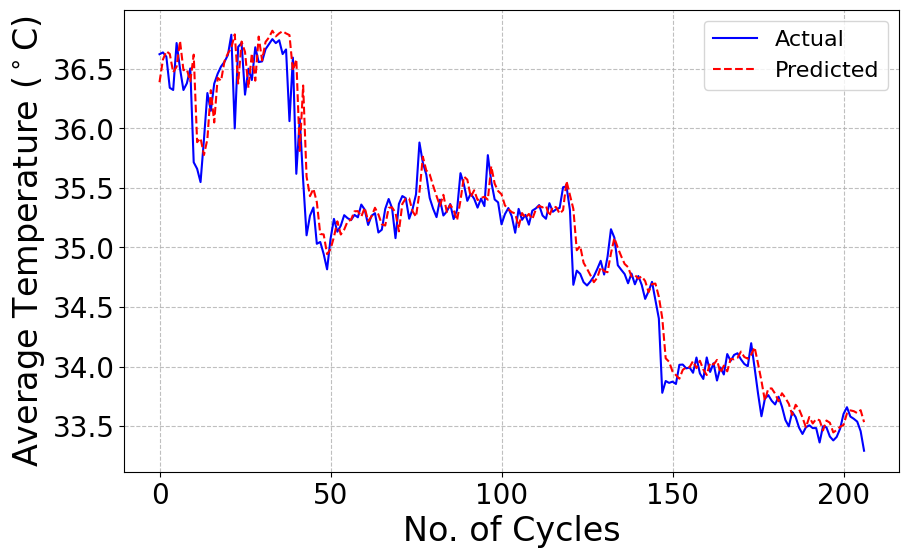

{'MAE': 0.1342396099023185,
 'MSE': 0.04086242848795239,
 'RMSE': np.float64(0.2021445732339911),
 'MAPE (%)': np.float64(0.38162102762898636)}

In [83]:
summary = bat_dict['b1c43']['summary']

# Select features and target
features = np.column_stack([
    #summary['QDischarge'],  # include target as input too (optional)
    #summary['QCharge'],
    summary['Tavg'],
    summary['Tmax'],
    summary['Tmin'],
    #summary['chargetime']
])

target_name = 'Tavg'
target = summary[target_name]  # what we want to predict

# Train
model, scaler_X, scaler_y, X_test, y_test = train_lstm_multivariate(
    summary['cycle'], features, target, window_size=6, epochs=50
)

#model.save(f"pred_models/for_Qcharge_Qcharge_discharge.keras") # Save the trained model

#model = tf.keras.models.load_model(f"pred_models/for_Tavg_Tavg_max_min.keras")

y_pred, y_true = test_lstm(model, scaler_y, X_test, y_test)

plot_predict_two_features(y_pred, y_true, y_title="Average Temperature ($^\circ$C)", y_label = "Predicted")

evaluate_predictions(y_true, y_pred)


### Train (QDischarge, Qcharge) -> Predict (QDischarge)

Epoch 1/100


/Users/manojherath/PythonProjects/Battery-Analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1162  
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2784e-04
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3699e-05
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0910e-05
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0099e-05
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2470e-05
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0041e-05
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9717e-05
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7834e-05
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3789e-05
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3408e-05
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3139e-05
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2351e-05
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4086e-05
Epoch 15/100
53/53 ━━━━━━━━━━

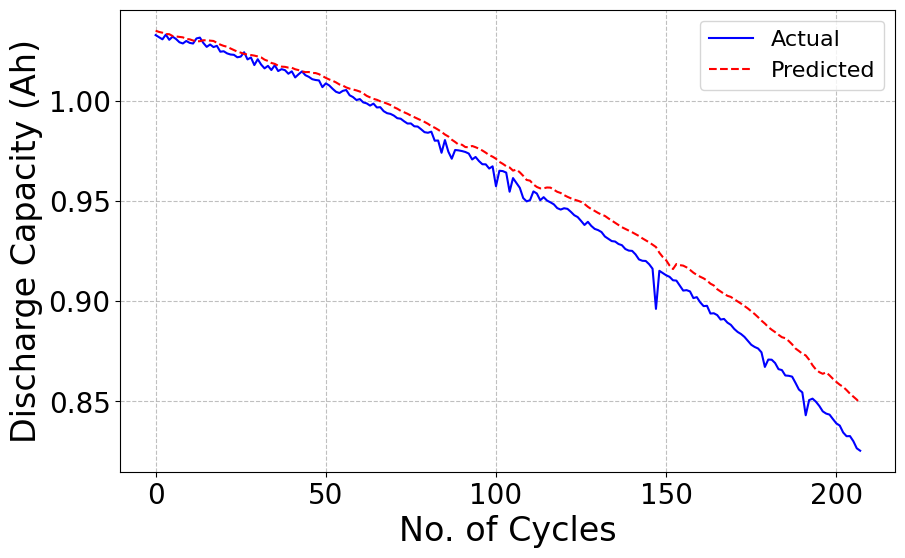

{'MAE': 0.008276823252306713,
 'MSE': 0.000108561961097606,
 'RMSE': np.float64(0.010419307131359839),
 'MAPE (%)': np.float64(0.9136699236088982)}

In [72]:
summary = bat_dict['b1c43']['summary']

# Select features and target
features = np.column_stack([
    summary['QDischarge'],  # include target as input too (optional)
    summary['QCharge'],
    #summary['Tavg'],
    #summary['Tmax'],
    #summary['Tmin'],
    #summary['chargetime']
])

target_name = 'QDischarge'
target = summary[target_name]  # what we want to predict

# Train
model, scaler_X, scaler_y, X_test, y_test = train_lstm_multivariate(
    summary['cycle'], features, target, window_size=5, epochs=100
)

#model.save(f"pred_models/for_Qcharge_Qcharge_discharge.keras") # Save the trained model

#model = tf.keras.models.load_model(f"pred_models/for_Tavg_Tavg_max_min.keras")

y_pred_qdis, y_true_qdis = test_lstm(model, scaler_y, X_test, y_test)

plot_predict_two_features(y_pred_qdis, y_true_qdis, y_title="Discharge Capacity (Ah)", y_label = "Predicted")

evaluate_predictions(y_true_qdis, y_pred_qdis)


### Train (Tavg, Tmax, Tmin) -> Predict (Tavg, Tmax, Tmin)

In [77]:
summary = bat_dict['b1c43']['summary']

# Multiple targets at once
features = np.column_stack([
    summary['QDischarge'],  # include target as input too (optional)
    summary['QCharge'],
    summary['Tavg'],
    summary['Tmax'],
    summary['Tmin'],
    #summary['chargetime']
])

# Predict multiple outputs simultaneously (e.g., Tavg, Tmax, Tmin)
targets = np.column_stack([
    summary['QDischarge'],  # include target as input too (optional)
    summary['QCharge'],
    summary['Tavg'],
    summary['Tmax'],
    summary['Tmin'],
    #summary['chargetime']
])

# Train
model, scaler_X, scaler_y, X_test, y_test = train_lstm_multivariate_2(
    summary['cycle'], features, targets, window_size=6, epochs=50
)

# Predict
y_pred, y_true = test_lstm_2(model, scaler_y, X_test, y_test)

# Example: plot only the first target
#plot_predict(y_pred[:,0], y_true[:,0], y_title="Tavg", y_label="Predicted")

evaluate_predictions_2(y_true, y_pred)


Epoch 1/50


/Users/manojherath/PythonProjects/Battery-Analysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0454 
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026    
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024  
Epoch 16/50
53/53 ━━━━━

{'Target_1': {'MAE': 0.015169372134623509,
  'MSE': 0.00033469313959236393,
  'RMSE': np.float64(0.018294620509657036),
  'MAPE (%)': np.float64(1.6677236510141005)},
 'Target_2': {'MAE': 0.004862144057986499,
  'MSE': 4.144473959410665e-05,
  'RMSE': np.float64(0.006437758895307175),
  'MAPE (%)': np.float64(0.5291055431319815)},
 'Target_3': {'MAE': 0.2775867243055545,
  'MSE': 0.10946457443313053,
  'RMSE': np.float64(0.33085430998119175),
  'MAPE (%)': np.float64(0.8013508162679511)},
 'Target_4': {'MAE': 0.3876766718431234,
  'MSE': 0.2147746074402008,
  'RMSE': np.float64(0.4634378139947158),
  'MAPE (%)': np.float64(1.0047692315473595)},
 'Target_5': {'MAE': 2.9089181306761933,
  'MSE': 15.594461822585194,
  'RMSE': np.float64(3.948982378105174),
  'MAPE (%)': np.float64(9.443577587895327)}}

### Calculate SOH

In [73]:
bat_dict['b1c43']['summary']['Tavg'][0]

np.float64(32.87494798855741)

In [74]:
Tavg_pred = y_pred_tavg # Tavg predicted
Tavg_true = y_true_tavg # Tavg true

QDischarge_pred = y_pred_qdis[:207,:] # QDischarge predicted
QDischarge_true = y_true_qdis[:207,:] # QDischarge true

#Tavg_pred = y_pred[:,2] # Tavg predicted
#Tavg_true = y_true[:,2] # Tavg true

#QDisharge_pred = y_pred[:,0] # QDischarge predicted
#QDischarge_true = y_true[:,0] # QDischarge true

QDischarge_initial = bat_dict['b1c43']['summary']['QDischarge'][0]
soh_pred = QDischarge_pred/QDischarge_initial*100
soh_true = QDischarge_true/QDischarge_initial*100


# Consider temperature effects on capacity
def temperature_correction_factor(temp, ref_temp=25):
    # Example: 0.1% capacity loss per °C above reference
    return 1 - 0.001 * abs(temp - ref_temp)

# Calculate adjusted SOH

adjusted_capacity_true = QDischarge_true / temperature_correction_factor(Tavg_true)
soh_adjusted_true = (adjusted_capacity_true / QDischarge_initial) * 100

adjusted_capacity_pred = QDischarge_pred / temperature_correction_factor(Tavg_pred)
soh_adjusted_pred = (adjusted_capacity_pred / QDischarge_initial) * 100

evaluate_predictions_2(soh_adjusted_true, soh_adjusted_pred)

{'Target_1': {'MAE': 0.7533391509791274,
  'MSE': 0.899874240810889,
  'RMSE': np.float64(0.9486170148225727),
  'MAPE (%)': np.float64(0.9028209461883383)}}

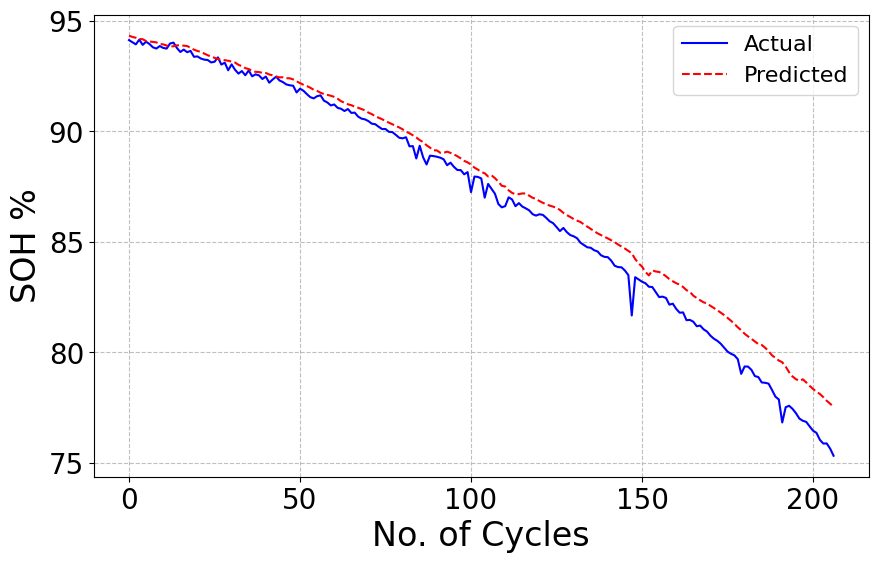

In [75]:
plot_predict_two_features(soh_pred, soh_true, y_title="SOH %", y_label="Predicted")

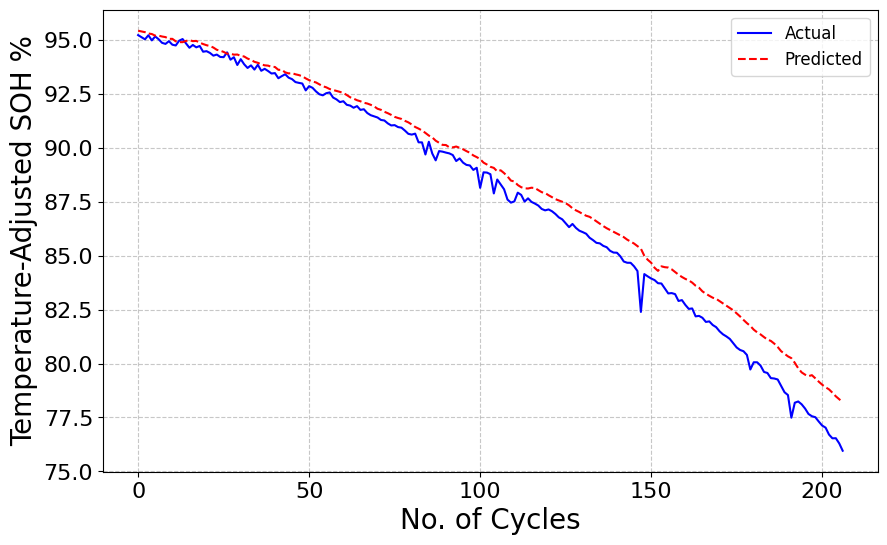

In [60]:
plot_predict_two_features(soh_adjusted_pred, soh_adjusted_true, y_title="Temperature-Adjusted SOH %", y_label="Predicted")

## Simulation

In [ ]:
float(np.mean(y_true[:,0]))

In [ ]:
float(np.mean(y_pred[:,0]))

In [ ]:
float(np.mean(y_sim[:,0]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


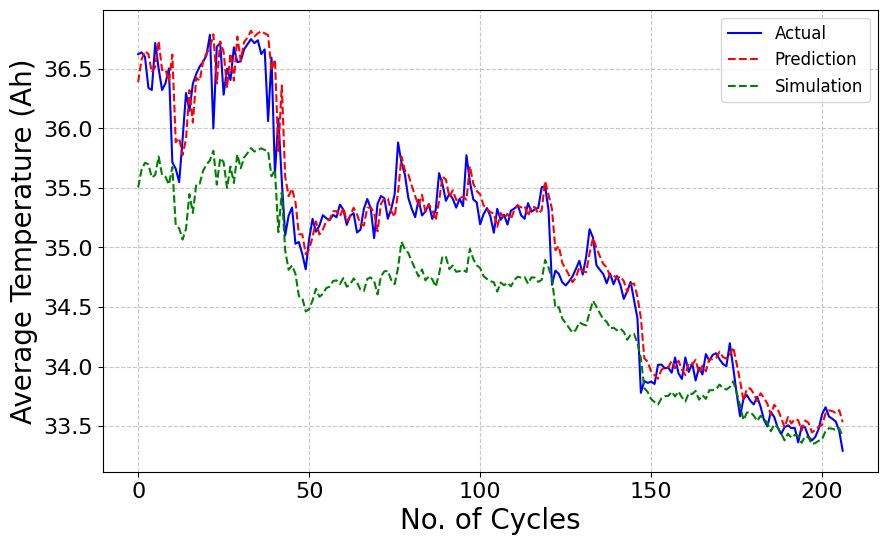

In [84]:
# Increase current value by 10%
y_sim, y_true = test_lstm_2(model, scaler_y, X_test*0.767, y_test)
plot_predict_three_features(y_pred, y_sim[:,0], y_true[:,0], y_title="Average Temperature (Ah)")